In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

from library.regression import LinearRegression
from library.selection import StepwiseSelection
from library.selection import Importance
from library.design_matrix import design_matrix

from sklearn.model_selection import train_test_split

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
# https://www.kaggle.com/neuromusic/avocado-prices
data = pd.read_csv('data/avocado.csv')

In [3]:
data.head()

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0           0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1           1  2015-12-20          1.35      54876.98   674.28   44638.81   
2           2  2015-12-13          0.93     118220.22   794.70  109149.67   
3           3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4           4  2015-11-29          1.28      51039.60   941.48   43838.39   

     4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0   48.16     8696.87     8603.62       93.25          0.0  conventional   
1   58.33     9505.56     9408.07       97.49          0.0  conventional   
2  130.50     8145.35     8042.21      103.14          0.0  conventional   
3   72.58     5811.16     5677.40      133.76          0.0  conventional   
4   75.78     6183.95     5986.26      197.69          0.0  conventional   

   year  region  
0  2015  Albany  
1  2015  Albany  
2  2015  Albany  
3  2015  Albany  
4  2015  Albany

In [4]:
data['type'].value_counts()
# There are two type: conventional and organic. There numbers are similar.

conventional    9126
organic         9123
Name: type, dtype: int64

In [5]:
data['year'].value_counts()
# There are four years and the number of 2018 is especially small.

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

In [6]:
data['region'].value_counts()
# The numbers are balanced.

Albany                 338
Pittsburgh             338
Philadelphia           338
Boston                 338
Charlotte              338
Tampa                  338
RaleighGreensboro      338
Boise                  338
Spokane                338
CincinnatiDayton       338
SanDiego               338
Plains                 338
MiamiFtLauderdale      338
Northeast              338
BaltimoreWashington    338
HarrisburgScranton     338
Sacramento             338
Chicago                338
GreatLakes             338
BuffaloRochester       338
Portland               338
Houston                338
SouthCarolina          338
Orlando                338
Roanoke                338
Seattle                338
StLouis                338
LasVegas               338
LosAngeles             338
NewOrleansMobile       338
Atlanta                338
Columbus               338
SouthCentral           338
Jacksonville           338
Syracuse               338
Southeast              338
Louisville             338
D

In [7]:
data.describe()

Unnamed: 0  AveragePrice  Total Volume          4046          4225  \
count  18249.000000  18249.000000  1.824900e+04  1.824900e+04  1.824900e+04   
mean      24.232232      1.405978  8.506440e+05  2.930084e+05  2.951546e+05   
std       15.481045      0.402677  3.453545e+06  1.264989e+06  1.204120e+06   
min        0.000000      0.440000  8.456000e+01  0.000000e+00  0.000000e+00   
25%       10.000000      1.100000  1.083858e+04  8.540700e+02  3.008780e+03   
50%       24.000000      1.370000  1.073768e+05  8.645300e+03  2.906102e+04   
75%       38.000000      1.660000  4.329623e+05  1.110202e+05  1.502069e+05   
max       52.000000      3.250000  6.250565e+07  2.274362e+07  2.047057e+07   

               4770    Total Bags    Small Bags    Large Bags    XLarge Bags  \
count  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   18249.000000   
mean   2.283974e+04  2.396392e+05  1.821947e+05  5.433809e+04    3106.426507   
std    1.074641e+05  9.862424e+05  7.461785e+05  2.439660e+05   17692.894652   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000   
25%    0.000000e+00  5.088640e+03  2.849420e+03  1.274700e+02       0.000000   
50%    1.849900e+02  3.974383e+04  2.636282e+04  2.647710e+03       0.000000   
75%    6.243420e+03  1.107834e+05  8.333767e+04  2.202925e+04     132.500000   
max    2.546439e+06  1.937313e+07  1.338459e+07  5.719097e+06  551693.650000   

               year  
count  18249.000000  
mean    2016.147899  
std        0.939938  
min     2015.000000  
25%     2015.000000  
50%     2016.000000  
75%     2017.000000  
max     2018.000000

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')

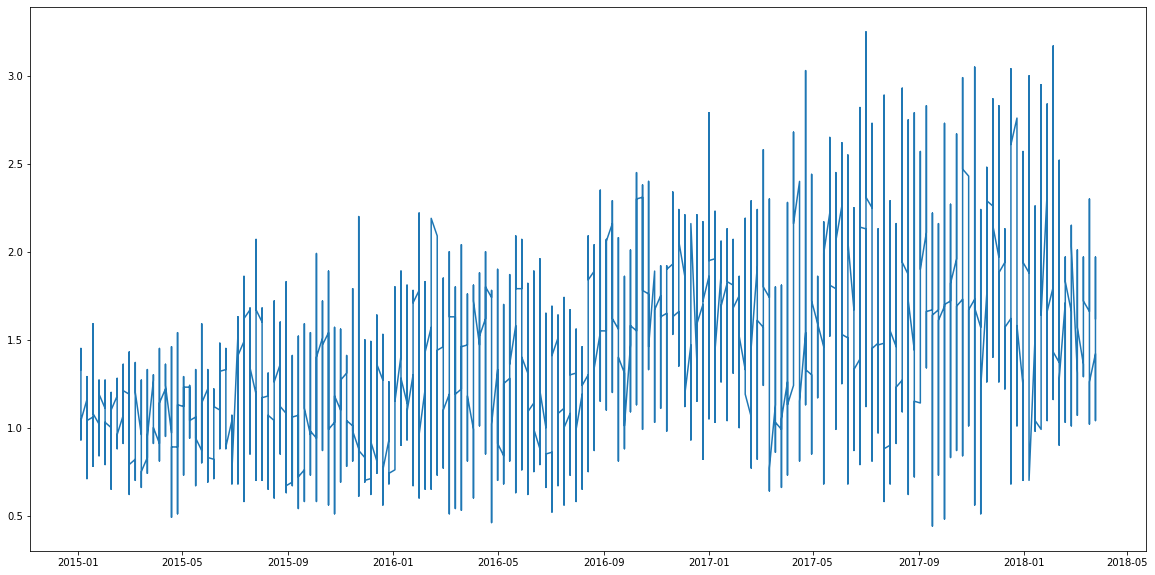

In [9]:
plt.figure(figsize=(20,10))
plt.plot(data['Date'].sort_values(), data['AveragePrice'])
plt.show()
# The price generally increases and is more fluctuated after 2016-09 

In [15]:
data['month'] = pd.DatetimeIndex(data['Date']).month

Unnamed: 0               int64
Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
4046                   float64
4225                   float64
4770                   float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                    object
year                     int64
region                  object
month                    int64
dtype: object

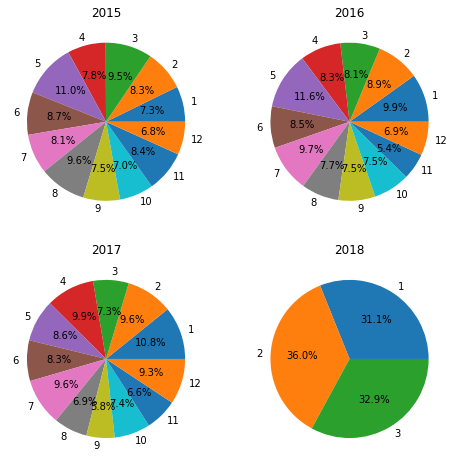

In [84]:
fig, axs = plt.subplots(2, 2)
years = [2015, 2016, 2017, 2018]
for i in range(len(years)):
    fig.set_figheight(8)
    fig.set_figwidth(8)
    months = np.sort(data[data['year'] == years[i]]['month'].value_counts().index).tolist()
    values = [data[(data['year'] == years[i]) & (data['month'] == x)]['Total Volume'].sum() for x in months]
    axs.flat[i].pie(values, labels = months, autopct='%1.1f%%')
    axs.flat[i].set_title(str(years[i]))
plt.show()

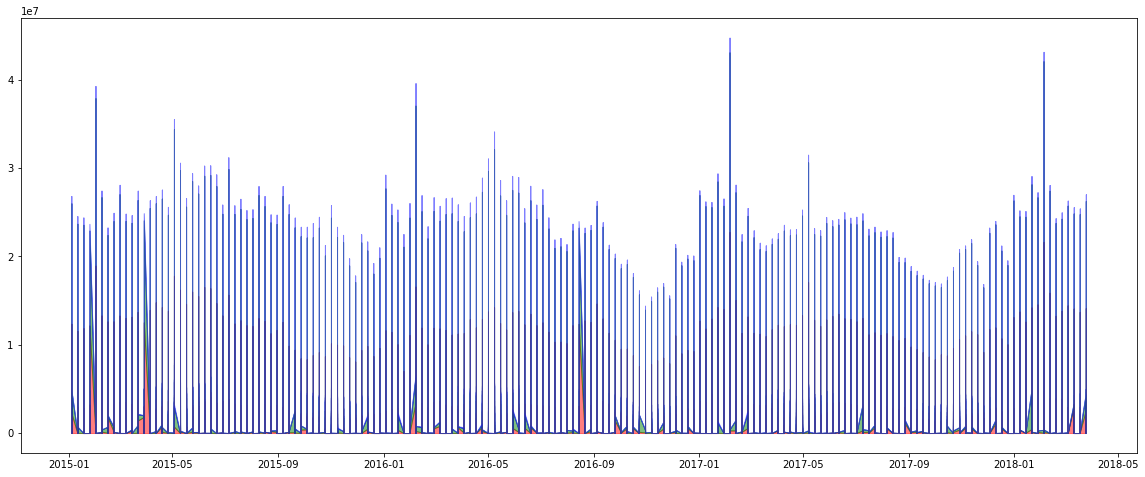

In [88]:
columns = ['4046', '4225', '4770']
colors = ['r', 'g', 'b']
y = np.zeros(len(data))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
for i in range(len(columns)):
    yp = np.copy(y)
    y += np.array(data.sort_values(by = 'Date')[columns[i]])
    ax.fill_between(data['Date'].sort_values(), yp, y, color = colors[i], alpha = 0.5)
plt.show()
# The voulume is a bit higher from April to July every year
# The volume decreases when it is in Winter

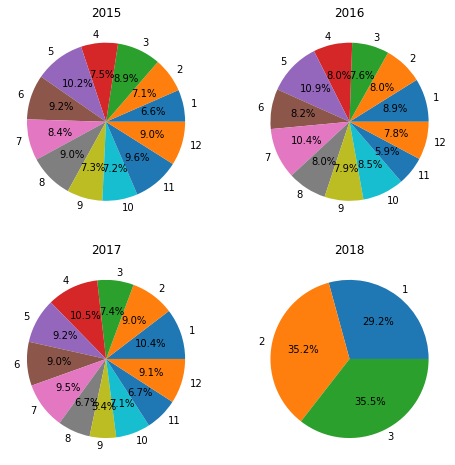

In [90]:
fig, axs = plt.subplots(2, 2)
years = [2015, 2016, 2017, 2018]
for i in range(len(years)):
    fig.set_figheight(8)
    fig.set_figwidth(8)
    months = np.sort(data[data['year'] == years[i]]['month'].value_counts().index).tolist()
    values = [data[(data['year'] == years[i]) & (data['month'] == x)]['Total Bags'].sum() for x in months]
    axs.flat[i].pie(values, labels = months, autopct='%1.1f%%')
    axs.flat[i].set_title(str(years[i]))
plt.show()

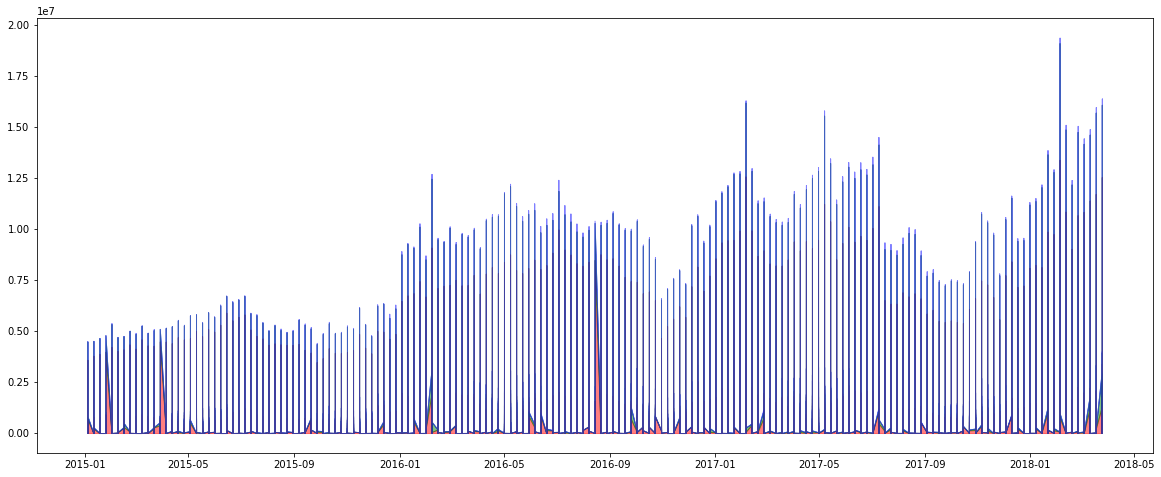

In [89]:
columns = ['Small Bags', 'Large Bags', 'XLarge Bags']
colors = ['r', 'g', 'b']
y = np.zeros(len(data))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
for i in range(len(columns)):
    yp = np.copy(y)
    y += np.array(data.sort_values(by = 'Date')[columns[i]])
    ax.fill_between(data['Date'].sort_values(), yp, y, color = colors[i], alpha = 0.5)
plt.show()
# The number of bags is increasing by year

In [13]:
data['type'] = data['type'].astype('category')
data['year'] = data['year'].astype('category')
data['region'] = data['region'].astype('category')

In [14]:
# The column is the index column
data = data.drop('Unnamed: 0', axis = 1)

In [15]:
train, test = train_test_split(data, test_size = 0.25)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [ ]:
train, validate = train_test_split(data, test_size = 2/9)
train = train.reset_index(drop = True)
validate = validate.reset_index(drop = True)

In [16]:
# Try to make the things simple
train = train.drop(['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags'], axis = 1)

In [17]:
# Try to drop the date
train = train.drop('Date', axis = 1)

In [ ]:
sns.pairplot(train)
plt.show()
# Total volume and total bags are highly correlated.

In [18]:
model = LinearRegression(train)
model.fit(['Total Volume', 'Total Bags', 'type', 'year', 'region'], 'AveragePrice', 
          category = ['type', 'year', 'region'], ascending = False)

In [19]:
model.summary(VIF = True)

Factor                                                 Coefficient         Pr(|t|>0)           VIF            
Intercept                                              1.2860              0.0000                             
Total Volume                                           -0.0000             0.0019              15.2748        
Total Bags                                             0.0000              0.0572              14.6598        
type_organic                                           0.4861              0.0000              -0.8891        
year_2016                                              -0.0377             0.0000              -1.4329        
year_2017                                              0.1335              0.0000              -1.4411        
year_2018                                              -0.0320             0.0008              -60.9047       
region_Atlanta                                         -0.2286             0.0000              -1.9968        
r

In [20]:
model = LinearRegression(train)
model.fit(['Total Volume', 'Total Bags', 'type', 'year', 'region'], 'AveragePrice', 
          category = ['type', 'year', 'region'], 
          interaction = [['type', 'Total Volume'], ['type', 'Total Bags'], ['type', 'year'], ['type', 'region'],
                         ['year', 'Total Volume'], ['year', 'Total Bags'], ['year', 'region'],
                         ['region', 'Total Volume'], ['region', 'Total Bags']], ascending = False)

In [21]:
model.summary()

Factor                                                 Coefficient         Pr(|t|>0)                          
Intercept                                              1.3380              0.0000                             
Total Volume                                           -0.0000             0.0003                             
Total Bags                                             0.0000              0.9179                             
type_organic                                           0.5480              0.0000                             
year_2016                                              0.1097              0.0030                             
year_2017                                              0.2103              0.0000                             
year_2018                                              0.2811              0.0000                             
region_Atlanta                                         0.2333              0.0640                             
r

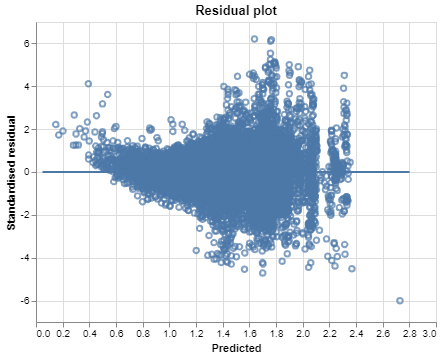

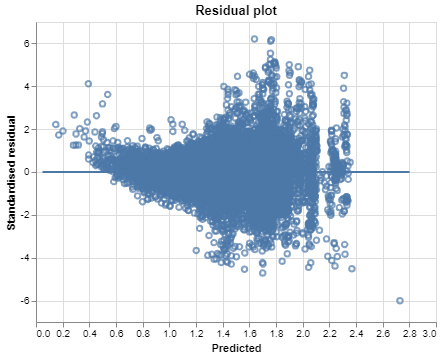

In [22]:
model.residual_plot()
# The plot likely has a shape

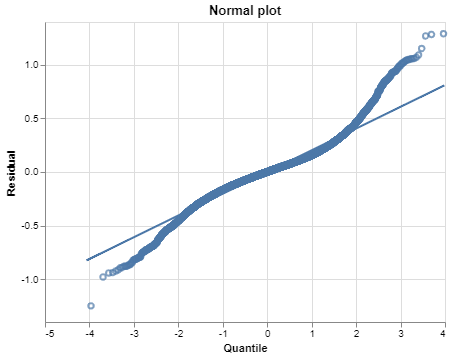

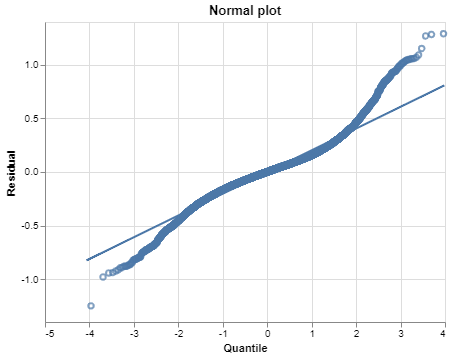

In [23]:
model.normal_plot()
# It is heavy-tailed

In [24]:
model.normal_test()
# The normality assumption fails

Test                               Test Statistic           Pr                  
Shapiro-Wilk                       0.9512                   0.0000              
Kolmogorov-Smirnov                 0.3244                   0.0000              
D’Agostino’s K^2                   1308.3507                0.0000              


C:\Users\imchtong\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
model.hypothesis_testing([{'type_organic_year_2018' : 1}, {'type_organic_year_2017' : 1}, {'type_organic_year_2016' : 1}], [0, 0, 0])
# The interaction between year and type is significant

Test statistic: 235.7580114887914
Pr: 1.1102230246251565e-16


In [26]:
type_region = [ ]
for col in model.columns.get('x'):
    if 'type' in col and 'region' in col:
        type_region.append({col : 1})

In [27]:
model.hypothesis_testing(type_region, [0] * len(type_region))
# The interaction effect between type and region is significant.

Test statistic: 10.412771995599567
Pr: 1.1102230246251565e-16


In [28]:
year_region = [ ]
for col in model.columns.get('x'):
    if 'year' in col and 'region' in col:
        year_region.append({col : 1})

In [29]:
model.hypothesis_testing(year_region, [0] * len(year_region))
# The interaction effect between year and region is significant

Test statistic: 9.225747867132302
Pr: 1.1102230246251565e-16


In [30]:
train = train[train['Total Bags'] != 0]
train = train.reset_index(drop=True)
train['log_total_volume'] = np.log(train['Total Volume'])
train['log_total_bag'] = np.log(train['Total Bags'])
train = train.drop(['Total Volume', 'Total Bags'], axis = 1)

In [31]:
model = LinearRegression(train)
model.fit(['log_total_volume', 'log_total_bag', 'type', 'year', 'region'], 'AveragePrice',
           category = ['type', 'year', 'region'], 
           interaction = [['type', 'log_total_volume'], ['type', 'log_total_bag'], ['type', 'year'], ['type', 'region'],
                          ['year', 'log_total_volume'], ['year', 'log_total_bag'], ['year', 'region'],
                          ['region', 'log_total_volume'], ['region', 'log_total_bag']], ascending = False)

In [32]:
model.summary()
# The r-square increases and AIC and BIC decrease

Factor                                                 Coefficient         Pr(|t|>0)                          
Intercept                                              5.0022              0.0000                             
log_total_volume                                       -0.5745             0.0000                             
log_total_bag                                          -0.0434             0.2041                             
type_organic                                           -3.5808             0.0000                             
year_2016                                              0.7388              0.0000                             
year_2017                                              2.7138              0.0000                             
year_2018                                              1.2615              0.0000                             
region_Atlanta                                         1.7812              0.0050                             
r

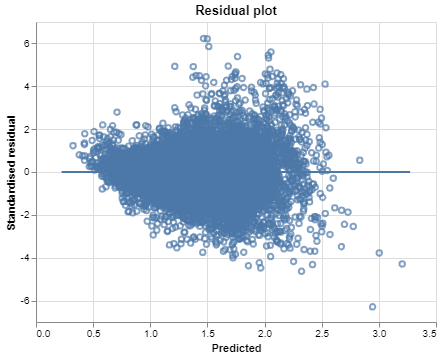

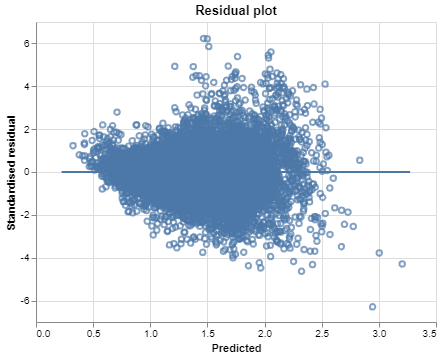

In [33]:
model.residual_plot()

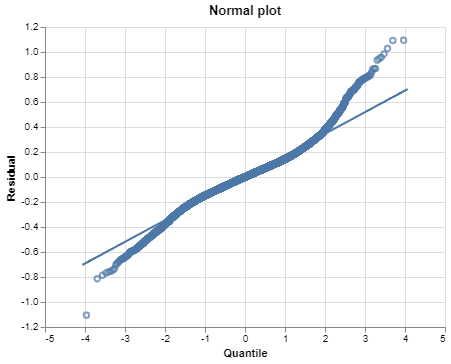

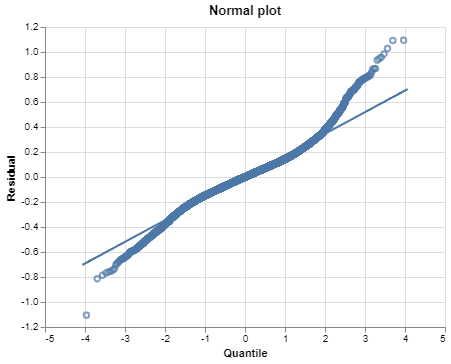

In [34]:
model.normal_plot()
# The plot fits better.

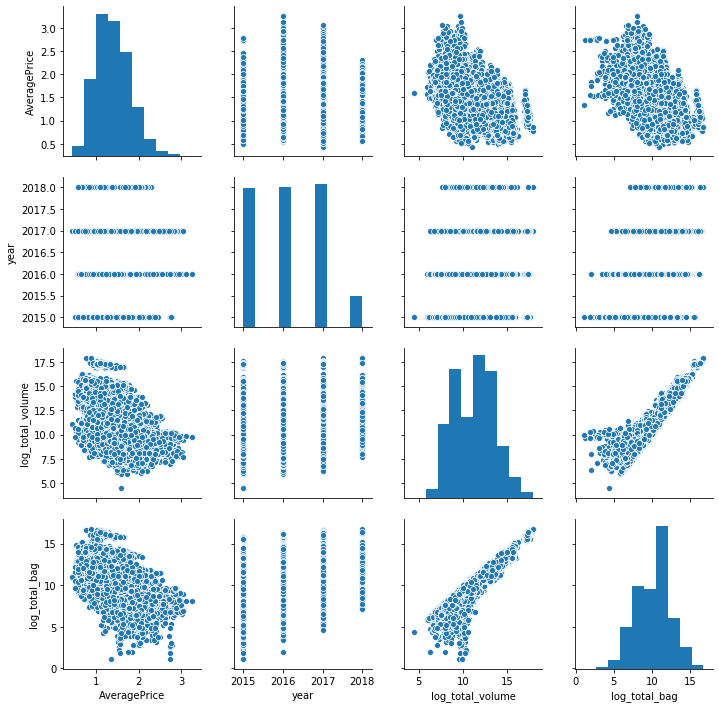

In [35]:
sns.pairplot(train)
plt.show()
# The scatter plot between price and total volume and that between price and total bags are more linear

In [36]:
dm = design_matrix(train, intercept = False,
           category = ['type', 'year', 'region'], 
           interaction = [['type', 'log_total_volume'], ['type', 'log_total_bag'], ['type', 'year'], ['type', 'region'],
                          ['year', 'log_total_volume'], ['year', 'log_total_bag'], ['year', 'region'],
                          ['region', 'log_total_volume'], ['region', 'log_total_bag']], ascending = False)

In [37]:
StepwiseSelection(dm, list(dm.drop(['AveragePrice'], axis = 1).columns), 'AveragePrice')

Variable in model: 
Variable Entered                                       Res S.S. before Entered            Res S.S. after Entered
type_organic                                           2195.5723                          1371.9246      
Test Statistic: 8209.3128811785
p-value: 1.1102230246251565e-16
Decision: Enter
------------------------------------------------------------------------------------------------------------------------
Variable in model: type_organic
Variable Entered                                       Res S.S. before Entered            Res S.S. after Entered
log_total_bag                                          1371.9246                          1294.6368      
Test Statistic: 816.2569361418417
p-value: 1.1102230246251565e-16
Decision: Enter
------------------------------------------------------------------------------------------------------------------------
Variable in model: type_organic, log_total_bag
Variable Removed                                       Res 

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth
Variable Removed                                       Res S.S. before Removal            Res S.S. after Removal
region_DallasFtWorth                                   1015.5819                          1033.9521      
Test Statistic: 247.19589028893526
p-value: 1.1102230246251565e-16
Decision: Do not remove
------------------------------------------------------------------------------------------------------------------------
Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth
Variable Entered                                       Res S.S. before Entered            Res S.S. after Entered
year_2017_log_total_bag                                1015.5819

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville
Variable Removed                                       Res S.S. before Removal            Res S.S. after Removal
region_Louisville                                      939.9122                           949.9511       
Test Statistic: 145.89829610482144
p-value: 1.1102230246251565e-16
Decision: Do not remove
------------------------------------------------------------------------------------------------------------------------
Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelp

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis
Variable Entered                                       Res S.S. before Entered            Res S.S. after Entered
region_RichmondNorfolk                                 893.3548                           885.3738       
Test Statistic: 123.0816382235748
p-value: 1.1102230246251565e-16
Decision: Enter
------------------------------------------------------------------------------------------------------------------------
Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile
Variable Removed                                       Res S.S. before Removal            Res S.S. after Removal
region_NewOrleansMobile                                854.3361                           861.9242       
Test Statistic: 121.2362012454459
p-value: 1.1102230246251565e-16
Decision: Do not remove
------------------------------------------------------------------------------------------------------

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017
Variable Removed                                       Res S.S. before Removal            Res S.S. after Removal
year_2017                                              826.6044                           832.8606       
Test Statistic: 103.27927883757083
p-value: 1.1102230246251565e-16
Decision: Do not remove
-------------

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta
Variable Removed                                       Res S.S. before Removal            Res S.S. after Removal
region_Atlanta                                         803.1475                           8

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag
Variable Entered                                       Res S.S. before Entered            Res S.S. after Ente

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume
Variable Entered 

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

Variable in model: type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_Californi

In [38]:
Importance(train, ['log_total_volume', 'log_total_bag', 'type', 'year', 'region'], 'AveragePrice', 
           category = ['type', 'year', 'region'], ntree = 5000)

Features  Importance
2              type    0.375225
4            region    0.205065
1     log_total_bag    0.179745
0  log_total_volume    0.176362
3              year    0.063603

In [ ]:
factors = '''
type_organic, log_total_bag, year_2017_log_total_volume, region_NewYork, region_HartfordSpringfield, region_Northeast, region_SanFrancisco, region_Houston, region_DallasFtWorth, year_2017_log_total_bag, region_Philadelphia, region_PhoenixTucson_log_total_bag, region_Nashville, region_TotalUS, region_Louisville, region_Columbus, region_Roanoke, region_Boise_log_total_bag, region_CincinnatiDayton, type_organic_region_Indianapolis, region_RichmondNorfolk, type_organic_region_Denver, type_organic_region_Detroit, type_organic_region_Pittsburgh, region_NewOrleansMobile, region_WestTexNewMexico, region_SouthCentral, year_2016_region_SanFrancisco, year_2017, region_HartfordSpringfield_log_total_volume, region_Spokane_log_total_bag, year_2018_log_total_volume, region_Atlanta, region_LasVegas_log_total_bag, type_organic_region_GrandRapids, region_Midsouth_log_total_bag, type_organic_region_MiamiFtLauderdale, type_organic_region_PhoenixTucson, log_total_volume, region_California, region_Southeast_log_total_volume, type_organic_region_Tampa, type_organic_region_Syracuse, region_West, region_GreatLakes_log_total_bag, region_Plains, region_BaltimoreWashington_log_total_bag, region_Albany_log_total_bag, type_organic_region_Seattle, region_LosAngeles, region_Chicago_log_total_bag, region_Boston_log_total_bag, year_2016_log_total_volume, year_2016_log_total_bag, region_Jacksonville_log_total_bag, region_Syracuse_log_total_volume, region_Pittsburgh, region_StLouis_log_total_bag, type_organic_region_BuffaloRochester, region_Indianapolis_log_total_volume, type_organic_region_Portland, type_organic_region_NewOrleansMobile, type_organic_year_2018, region_SanFrancisco_log_total_volume, type_organic_region_SanFrancisco, region_SanFrancisco_log_total_bag, region_MiamiFtLauderdale_log_total_volume, region_Seattle, region_Seattle_log_total_volume, region_Denver, region_HartfordSpringfield_log_total_bag, type_organic_region_RaleighGreensboro, region_NorthernNewEngland, type_organic_log_total_volume, region_Pittsburgh_log_total_bag, region_Houston_log_total_bag, type_organic_region_SouthCentral, region_LasVegas, type_organic_region_DallasFtWorth, type_organic_region_TotalUS, region_Portland, region_Portland_log_total_volume, region_Sacramento_log_total_volume, type_organic_region_SanDiego, type_organic_region_Charlotte, year_2017_region_Pittsburgh, region_StLouis_log_total_volume, type_organic_region_HarrisburgScranton, region_Tampa_log_total_volume, region_CincinnatiDayton_log_total_volume, type_organic_log_total_bag, region_BuffaloRochester, region_Roanoke_log_total_bag, type_organic_region_California, region_GrandRapids_log_total_volume, type_organic_region_Spokane, type_organic_region_LosAngeles, region_SanDiego, region_Northeast_log_total_bag, region_BuffaloRochester_log_total_bag, region_MiamiFtLauderdale, year_2017_region_PhoenixTucson, region_SanDiego_log_total_volume, year_2017_region_Nashville, region_Columbus_log_total_volume, region_Tampa, region_Tampa_log_total_bag, region_Charlotte, region_MiamiFtLauderdale_log_total_bag, region_Nashville_log_total_bag, year_2016_region_Philadelphia, region_California_log_total_volume, year_2018_region_BuffaloRochester, type_organic_region_Atlanta, type_organic_region_West, region_West_log_total_volume, type_organic_region_Southeast, region_Boston, type_organic_region_Plains, year_2018_region_Boise, year_2016_region_LasVegas, region_Louisville_log_total_bag, year_2016_region_BaltimoreWashington, year_2016_region_Sacramento, year_2017_region_BuffaloRochester, year_2016_region_HartfordSpringfield, type_organic_region_GreatLakes, region_GreatLakes, region_NewYork_log_total_bag, type_organic_region_NewYork, region_Syracuse, region_Charlotte_log_total_bag, region_BaltimoreWashington, year_2018_region_Pittsburgh, region_HarrisburgScranton, region_HarrisburgScranton_log_total_bag, year_2016_region_HarrisburgScranton, type_organic_region_Boston, year_2016_region_Syracuse, year_2017_region_Philadelphia, year_2016_region_Albany, year_2018, type_organic_region_HartfordSpringfield, year_2017_region_BaltimoreWashington, year_2018_region_Syracuse, year_2017_region_Syracuse, type_organic_region_Orlando, year_2016_region_NewYork, type_organic_region_Houston, type_organic_region_Midsouth, region_Pittsburgh_log_total_volume, year_2017_region_TotalUS, year_2017_region_LosAngeles, type_organic_year_2017, region_California_log_total_bag, year_2017_region_NewOrleansMobile, region_NewOrleansMobile_log_total_volume, region_Orlando_log_total_volume, region_LosAngeles_log_total_volume, year_2018_region_LosAngeles, year_2016_region_LosAngeles, region_LosAngeles_log_total_bag, region_Philadelphia_log_total_bag, year_2017_region_MiamiFtLauderdale, year_2017_region_Southeast, region_BuffaloRochester_log_total_volume, type_organic_region_Philadelphia, region_PhoenixTucson, region_PhoenixTucson_log_total_volume, region_Orlando_log_total_bag, region_Orlando, region_Jacksonville_log_total_volume, year_2017_region_Boston, year_2017_region_Northeast, year_2016_region_Northeast, year_2018_region_Boston, year_2017_region_RaleighGreensboro, year_2017_region_Seattle, year_2018_region_Seattle, year_2016_region_Denver, year_2017_region_Denver, year_2016_region_West, year_2017_region_Midsouth, year_2017_region_GreatLakes, year_2017_region_California, year_2017_region_SouthCentral, year_2017_region_West, year_2017_region_NewYork, year_2017_region_Plains, year_2017_region_Portland, year_2017_region_Louisville, year_2017_region_Albany, year_2017_region_Chicago, year_2016_region_GrandRapids, region_Boise_log_total_volume, year_2017_region_Indianapolis, region_Indianapolis, year_2017_region_Houston, region_Southeast, year_2017_region_DallasFtWorth, year_2016_region_Pittsburgh, year_2018_region_Roanoke, region_RaleighGreensboro, region_RaleighGreensboro_log_total_bag, type_organic_region_Sacramento, region_Sacramento, year_2018_region_SanFrancisco, year_2018_log_total_bag, region_Sacramento_log_total_bag, region_Portland_log_total_bag, region_Philadelphia_log_total_volume, region_West_log_total_bag, year_2018_region_West, year_2017_region_Spokane, region_Seattle_log_total_bag, year_2018_region_Jacksonville, year_2018_region_StLouis, year_2016_region_NorthernNewEngland, year_2016_region_Atlanta, year_2017_region_GrandRapids, region_Plains_log_total_volume, region_GrandRapids_log_total_bag, year_2018_region_Spokane, region_Spokane, region_Spokane_log_total_volume, year_2017_region_SanDiego, year_2018_region_SanDiego, year_2016_region_SanDiego, region_SanDiego_log_total_bag, year_2016_region_Charlotte, year_2018_region_Southeast, year_2018_region_LasVegas, region_GreatLakes_log_total_volume
'''